## Neural network workflow

This notebook describes the workflow for training neural networks

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import models
import platform

from os.path import expanduser
from os import path
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util
from yass.augment import make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.templates import TemplatesProcessor

import numpy as np
from scipy.io import loadmat

from dstools import plot

LOCAL = platform.system() == 'Darwin'

# logging.basicConfig(level=logging.DEBUG)

Using TensorFlow backend.


In [3]:
# for reference
print('YASS version is: {}'.format(util.get_version()))

YASS version is: 96796f6 fixes slice creation


In [4]:
if LOCAL:
    yass.set_config("../config/49-local.yaml")
else:
    yass.set_config("../config/49-lab.yaml")

CONFIG = read_config()

In [5]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'nnet')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

if LOCAL:
    path_to_here = path.expanduser('~/dev/lab/private-yass/nnet')
else:
    path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [6]:
# load ground truth
_ = loadmat(path_to_ground_truth)
spike_train = np.hstack([_['spt_gt'], _['L_gt']])

# remove spikes at the beginning (2) and end (1) to avoid errors
# when getting waveforms
spike_train = spike_train[2:-1]

# shift ids to start at 0
spike_train[:, 1] = spike_train[:, 1] - 1

# compensate alignment
spike_train[:, 0] = spike_train[:, 0] + 10

In [7]:
def filename(extension=None):
    """Generate a valid directory name with the current datetime
    """
    now = datetime.datetime.now()
    name =  now.strftime('%d-%b-%Y@%H-%M-%S')
    
    if extension is not None:
        name += '.'+extension
    
    return name

## Visualizing templates

In [8]:
# use all templates
n_templates = np.max(spike_train[:,1]) + 1
chosen_templates_indexes = np.arange(n_templates)

# chosen_templates = [0, 1, 2, 3, 4, 5, 7, 8, 9, 11,
#                     12, 13, 14, 15, 16, 17, 18, 19,
#                     22, 23, 24, 25, 26, 27, 28, 29,
#                     30, 31, 32, 33, 34, 35, 36, 37,
#                     38, 39, 41, 42, 43, 44, 45, 46,
#                     47, 48]

In [9]:
# load 4x templates
processor = TemplatesProcessor.from_spike_train(CONFIG,
                                                4 * CONFIG.spike_size,
                                                spike_train,
                                                path_to_standarized)

processor.choose_with_indexes(chosen_templates_indexes, inplace=True)
processor.choose_with_minimum_amplitude(4, inplace=True)

templates_uncropped = processor.templates

processor.align(CONFIG.spike_size, inplace=True)
templates = (processor.crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
             .values)

100%|██████████| 3/3 [00:15<00:00,  5.09s/it]


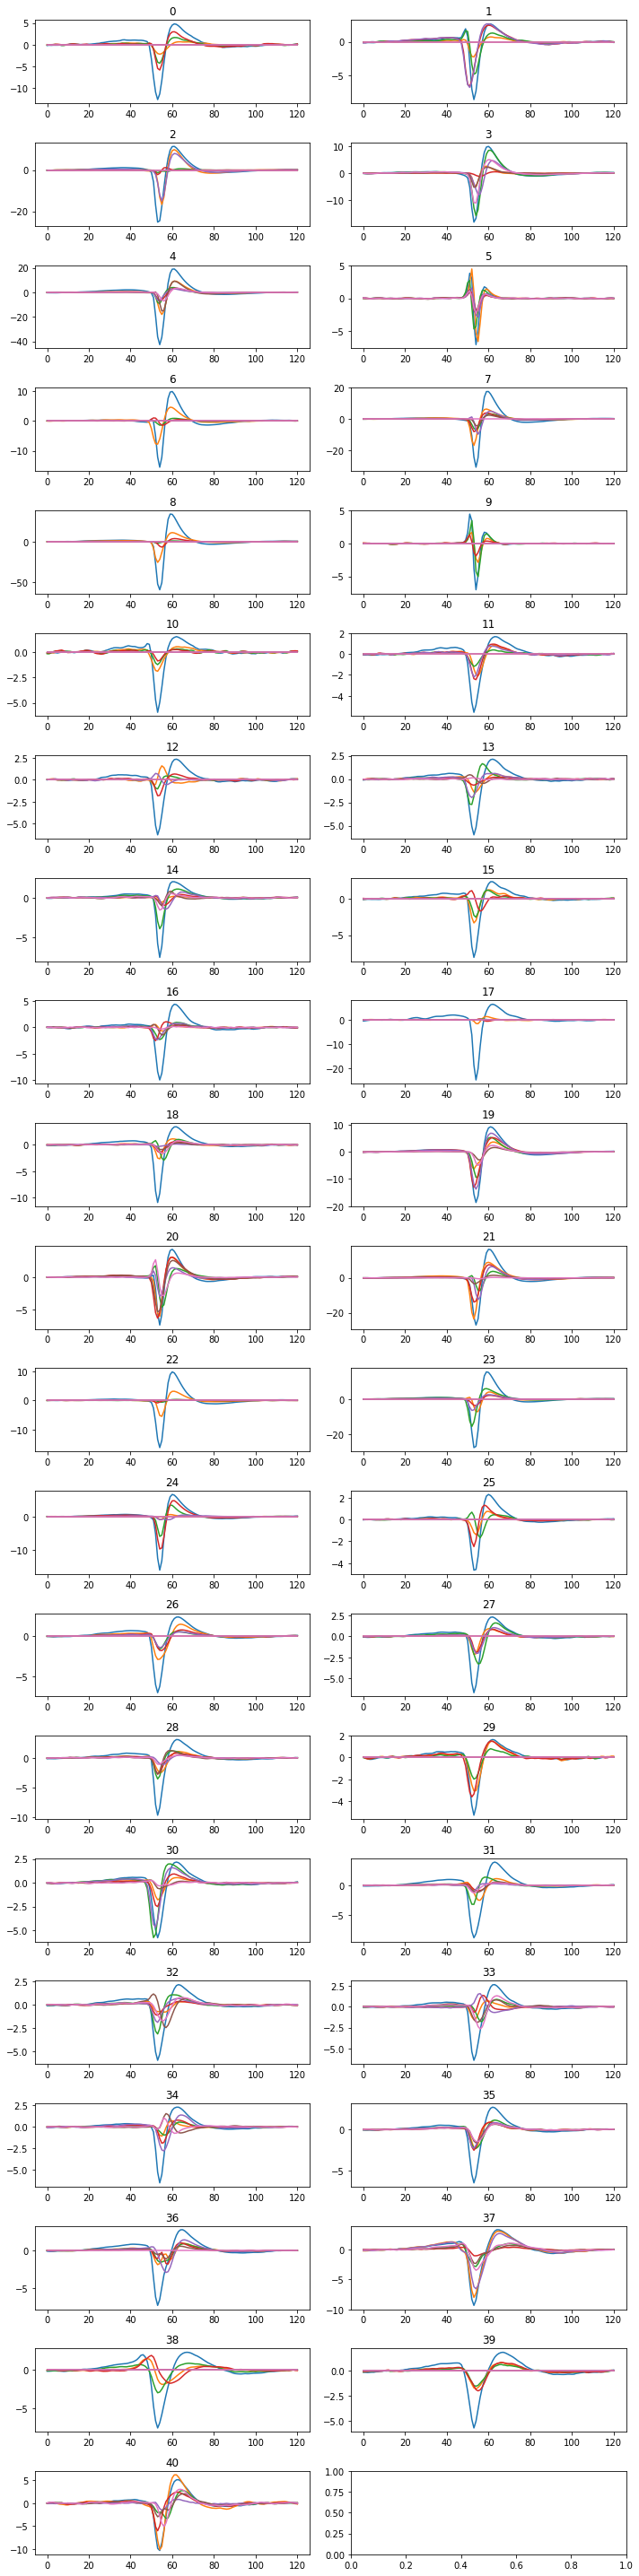

In [10]:
# this is just a handy plotting function, you don't actually
# need it
plot.grid_from_array(templates, axis=0, figsize=(10, 40),
                     max_cols=2)

## Generating training data

In [19]:
n_spikes = 20000
min_amplitude = 3
max_amp = 40
noise_ratio = 2
multi_channel = True

In [20]:
(x_detect, y_detect,
 x_triage, y_triage,
 x_ae, y_ae) = make.training_data(CONFIG, spike_train,
                                  chosen_templates_indexes,
                                  min_amplitude, max_amp, n_spikes,
                                  data_folder=path_to_experiment,
                                  multi_channel=True,
                                  noise_ratio=noise_ratio)

100%|██████████| 3/3 [00:14<00:00,  4.88s/it]


In [21]:
print(f'Training set sizes:\n\tdetect:{x_detect.shape}\n\ttriage:{x_triage.shape}\n\tautoencoder:{x_ae.shape}')

Training set sizes:
	detect:(100040, 41, 7)
	triage:(40016, 41, 7)
	autoencoder:(195688, 41)


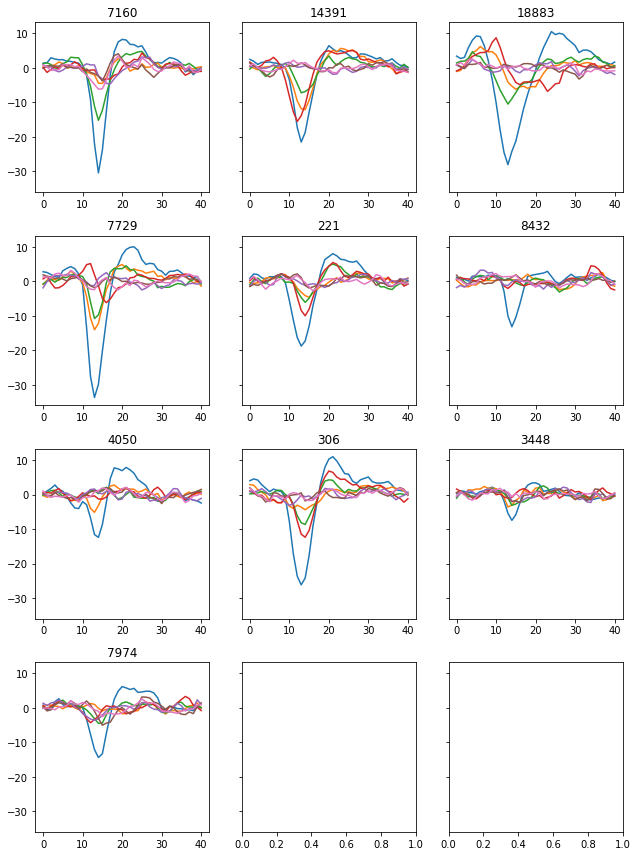

In [22]:
plot.grid_from_array(x_triage[y_triage == 1], axis=0,
                     elements=10,
                     auto_figsize=3, sharey=True)

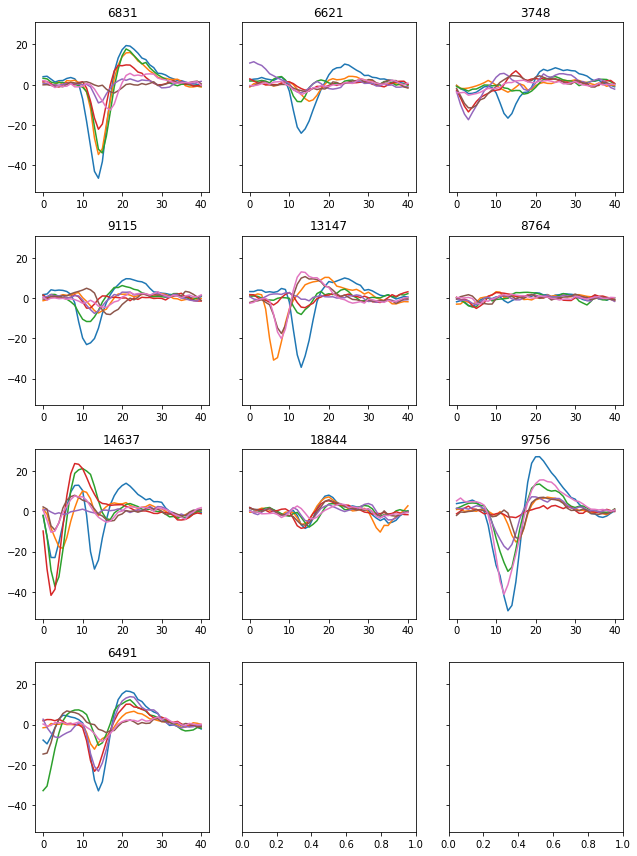

In [23]:
plot.grid_from_array(x_triage[y_triage == 0], axis=0,
                     elements=10,
                     auto_figsize=3, sharey=True)

# Training

In [16]:
import models
from sklearn.model_selection import train_test_split

x = x_triage[:, : , :, np.newaxis]

(x_train, x_test,
y_train, y_test) = train_test_split(x, y_triage, test_size=0.3)

_, wf, ch, _ = x_train.shape

m = models.default_model(x, (wf, ch, 1))

In [17]:
m.fit(x_train, y_train,
          batch_size=128, epochs=10, shuffle=True,
          validation_data=(x_test, y_test))

Train on 28011 samples, validate on 12005 samples
Epoch 1/10
28011/28011 [==============================] - 5s 172us/step - loss: 7.9920 - acc: 0.4987 - val_loss: 7.9227 - val_acc: 0.5030
Epoch 2/10
28011/28011 [==============================] - 1s 44us/step - loss: 7.9920 - acc: 0.4987 - val_loss: 7.9227 - val_acc: 0.5030
Epoch 3/10
28011/28011 [==============================] - 1s 44us/step - loss: 7.9920 - acc: 0.4987 - val_loss: 7.9227 - val_acc: 0.5030
Epoch 4/10
28011/28011 [==============================] - 1s 44us/step - loss: 7.9920 - acc: 0.4987 - val_loss: 7.9227 - val_acc: 0.5030
Epoch 5/10
28011/28011 [==============================] - 1s 44us/step - loss: 7.9920 - acc: 0.4987 - val_loss: 7.9227 - val_acc: 0.5030
Epoch 6/10
28011/28011 [==============================] - 1s 44us/step - loss: 7.9920 - acc: 0.4987 - val_loss: 7.9227 - val_acc: 0.5030
Epoch 7/10
28011/28011 [==============================] - 1s 44us/step - loss: 7.9920 - acc: 0.4987 - val_loss: 7.9227 - val_ac

In [18]:
x_train.shape

(28011, 41, 7, 1)